# Library

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Parser

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Input Datasets

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(dataset.head())

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64


# Plotting

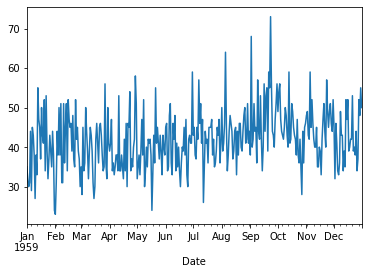

In [ ]:
dataset.plot()
plt.show()

# Processing Time-series Data

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# BaseLine Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.1068 - val_loss: 0.0665
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1052 - val_loss: 0.0657
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1042 - val_loss: 0.0651
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1032 - val_loss: 0.0647
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1024 - val_loss: 0.0643
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1017 - val_loss: 0.0639
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1010 - val_loss: 0.0635
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1005 - val_loss: 0.0632
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0999 - val_loss: 0.0629
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0993 - val_loss: 0.0625
Epoch 11/1000
9/9 

In [ ]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0547
Test loss: 0.054678257554769516


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
81,0.081073,0.054389,81
89,0.080878,0.054402,89
88,0.080910,0.054402,88
82,0.081006,0.054405,82
79,0.081106,0.054409,79
...,...,...,...
4,0.102367,0.064278,4
3,0.103179,0.064658,3
2,0.104198,0.065094,2
1,0.105246,0.065713,1


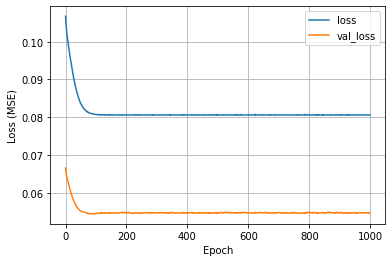

In [ ]:
plot_loss(history) # epoch vs loss graph

# Deeper Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0852 - val_loss: 0.0544
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0842 - val_loss: 0.0541
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.0538
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0537
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.0537
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.0538
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0820 - val_loss: 0.0538
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0538
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0538
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0814 - val_loss: 0.0538
Epoch 11/1000
9/9 

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
4,0.082564,0.053670,4
3,0.082944,0.053728,3
5,0.082276,0.053752,5
6,0.081988,0.053767,6
9,0.081368,0.053771,9
...,...,...,...
367,0.080597,0.054967,367
292,0.080686,0.054989,292
800,0.080787,0.054996,800
909,0.080728,0.054998,909


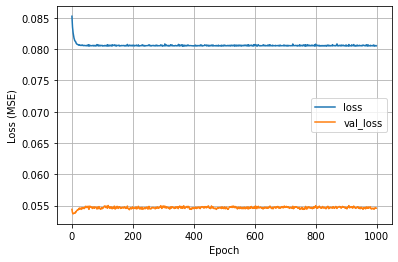

In [ ]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider Model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1002 - val_loss: 0.0607
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0576
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0877 - val_loss: 0.0565
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0857 - val_loss: 0.0560
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0845 - val_loss: 0.0556
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.0553
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.0547
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0544
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0827 - val_loss: 0.0550
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0546
Epoch 11/1000
9/9 

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
11,0.081686,0.054097,11
97,0.080591,0.054100,97
222,0.080685,0.054119,222
535,0.080355,0.054124,535
213,0.080555,0.054133,213
...,...,...,...
587,0.080618,0.055959,587
3,0.085744,0.055964,3
2,0.087651,0.056498,2
1,0.091870,0.057566,1


# LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 0.1076 - val_loss: 0.0665
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1044 - val_loss: 0.0647
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1019 - val_loss: 0.0633
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0998 - val_loss: 0.0622
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0978 - val_loss: 0.0614
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0962 - val_loss: 0.0605
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0948 - val_loss: 0.0597
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0931 - val_loss: 0.0591
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0918 - val_loss: 0.0584
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0904 - val_loss: 0.0578
Epoch 11/1000
9/9 

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
143,0.080523,0.054403,143
167,0.080448,0.054433,167
105,0.080489,0.054435,105
40,0.080735,0.054457,40
166,0.080388,0.054464,166
...,...,...,...
4,0.097774,0.061353,4
3,0.099815,0.062194,3
2,0.101932,0.063303,2
1,0.104440,0.064715,1


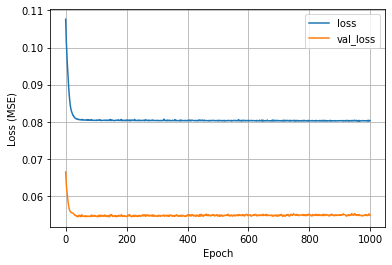

In [ ]:
plot_loss(lstm_model_history)

# Kesimpulan

Pada datasets Birth, Model terbaik yaitu Deeper Model dengan hasil terbaik pada Epoch 4 dengan nilai loss: 0.0829 - val_loss: 0.0537 